In [ ]:
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import sys

import csv
import h5py
import ast
import matplotlib.pyplot as plt

raw_dataset = []
with open('sequence_dataset2.csv', encoding='latin-1') as f:
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        raw_dataset.append([line[0], line[1], line[2]])

dataset = []
for (sent, indices, labels) in raw_dataset:
  sentences = []
  labels = labels[1:len(labels)-1].split(",")
  for (w, label) in zip(sent.split(" "), labels):
    sentences.append((w, int(label.strip())))
  dataset.append(sentences)

train_sents = dataset[:int(0.8*len(dataset))]
dev_sents = dataset[int(0.8*len(dataset)):int(0.9*len(dataset))]
test_sents = dataset[int(0.9*len(dataset)):]

train_sents[:3]

[[('By', 2), ('FRANK', 0), ('KANE', 0)],
 [('IT', 2),
  ('SEEMS', 0),
  ('that', 2),
  ('Roland', 0),
  ('Franklin', 0),
  (',', 2),
  ('the', 2),
  ('latest', 0),
  ('unbundler', 0),
  ('to', 2),
  ('appear', 0),
  ('in', 2),
  ('the', 2),
  ('UK', 0),
  (',', 2),
  ('has', 2),
  ('made', 1),
  ('a', 2),
  ('fatal', 1),
  ('error', 0),
  ('in', 2),
  ('the', 2),
  ('preparation', 0),
  ('of', 2),
  ('his', 2),
  ('697m', 2),
  ('break-up', 0),
  ('bid', 0),
  ('for', 2),
  ('stationery', 0),
  ('and', 2),
  ('packaging', 0),
  ('group', 0),
  ('DRG', 0),
  ('.', 2)],
 [('He', 2),
  ('has', 2),
  ('not', 2),
  ('properly', 0),
  ('investigated', 0),
  ('the', 2),
  ('target', 1),
  ("'s", 2),
  ('dining', 0),
  ('facilities', 0),
  ('.', 2)]]

In [ ]:
!pip uninstall torchtext

Found existing installation: torchtext 0.15.1
Uninstalling torchtext-0.15.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchtext-0.15.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchtext/*
Proceed (Y/n)? y
  Successfully uninstalled torchtext-0.15.1


In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00


In [ ]:
from torchtext.data import Example
from torchtext.data import Field, Dataset

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

def read_data(sentences):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for sentence in sentences: 
        tokens = [t[0] for t in sentence]
        labels = [t[1] for t in sentence]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])

train_data = read_data(train_sents)
dev_data = read_data(dev_sents)
test_data = read_data(test_sents)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(dev_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x7f1402a1be50>, 'text': <torchtext.data.field.Field object at 0x7f1402a1baf0>}
['By', 'FRANK', 'KANE']
[2, 0, 0]
Train: 9686
Dev: 1211
Test: 1211


In [ ]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
dev_iter = BucketIterator(dataset=dev_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/"UTD coursework"/"Semester 4"/"Deep Learning for NLP"/project/glove.840B.300d.zip

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2023-05-05 23:31:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.141.40, 13.249.141.108, 13.249.141.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.141.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   234MB/s    in 2.8s    

2023-05-05 23:31:34 (234 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import random
import os
import numpy as np

EMBEDDING_PATH = os.path.join(os.path.expanduser("~"), "/content/wiki-news-300d-1M.vec")

def load_embeddings(path):
    """ Load the FastText embeddings from the embedding file. """
    print("Loading pre-trained embeddings")
    
    embeddings = {}
    with open(path) as i:
        for line in i:
            if len(line) > 2: 
                line = line.strip().split()
                word = line[0]
                embedding = np.array(line[1:])
                embeddings[word] = embedding
    
    return embeddings
    

def initialize_embeddings(embeddings, vocabulary):
    """ Use the pre-trained embeddings to initialize an embedding matrix. """
    print("Initializing embedding matrix")
    embedding_size = len(embeddings["."])
    embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                
    for idx, word in enumerate(vocabulary.itos): 
        if word in embeddings:
            embedding_matrix[idx,:] = embeddings[word]
            
    return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix).to(device)

Loading pre-trained embeddings
Initializing embedding matrix


In [ ]:
# import pickle

# with open('embeddings.pickle', 'wb') as handle:
#     pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# !cp embeddings.pickle "/content/drive/MyDrive/UTD coursework/Semester 4/Deep Learning for NLP/project"

In [ ]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [ ]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report


def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

# 61566 - 0, 11044 - 1, 108878 - 2
def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    # weight=torch.FloatTensor([0, 0, 0.06, 1.0]).to(device) weight=torch.FloatTensor([0, 0, 14.5, 17.4, 1.0]).to(device) weight=torch.FloatTensor([0, 0, 1.77, 9.86, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    labels = label_field.vocab.itos[2:]
    label_idxs = [label_field.vocab.stoi[l] for l in labels]
    target_names = [str(x) for x in labels]

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape

            # print(batch.text[0],batch.text[1])
            # print(text_length, cur_batch_size)
            
            pred = model(batch.text[0].to(device), batch.text[1].to('cpu')).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)
        print(classification_report(correct, predictions, labels=label_idxs, target_names=target_names))
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to('cpu')).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)
        print(classification_report(correct, predictions, labels=label_idxs, target_names=target_names))
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        # if no_improvement > patience:
        #     print("Development F-score does not improve anymore. Stop training.")
        #     dev_f_score_history.append(dev_f)
        #     break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

In [ ]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to('cpu')).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                               correct_labels)

        predictions += predicted_labels
        correct += correct_labels

        
    test_scores = precision_recall_fscore_support(correct, predictions, average="micro")
    
    print('test perf', test_scores)
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [ ]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
MAX_EPOCHS = 15
PATIENCE = 30
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  

train_f, dev_f = train(tagger.to(device), train_iter, dev_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 0:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 124.90004653483629
Training performance: (0.8441555284063627, 0.8441555284063627, 0.8441555284063627, None)
              precision    recall  f1-score   support

           2       0.88      0.96      0.92     97123
           0       0.79      0.80      0.79     56787
           1       0.51      0.03      0.06     10613

   micro avg       0.84      0.84      0.84    164523
   macro avg       0.72      0.60      0.59    164523
weighted avg       0.82      0.84      0.82    164523

Total development loss: 7.913271442055702
Development performance: (0.922699627231705, 0.922699627231705, 0.9226996272317051, None)
              precision    recall  f1-score   support

           2       0.94      0.99      0.96      7102
           0       0.89      0.84      0.86      2842
           1       0.20      0.06      0.09       250

    accuracy                           0.92     10194
   macro avg       0.68      0.63      0.64     10194
weighted avg       0.91      0.9

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 1:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 64.43621654435992
Training performance: (0.9087908681460951, 0.9087908681460951, 0.9087908681460951, None)
              precision    recall  f1-score   support

           2       0.97      0.98      0.98     97123
           0       0.83      0.93      0.88     56787
           1       0.53      0.15      0.23     10613

    accuracy                           0.91    164523
   macro avg       0.78      0.69      0.70    164523
weighted avg       0.89      0.91      0.89    164523

Total development loss: 7.096186600625515
Development performance: (0.927212085540514, 0.927212085540514, 0.927212085540514, None)
              precision    recall  f1-score   support

           2       0.94      0.99      0.97      7102
           0       0.91      0.82      0.87      2842
           1       0.30      0.17      0.22       250

    accuracy                           0.93     10194
   macro avg       0.72      0.66      0.68     10194
weighted avg       0.92      0.93 

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 2:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 58.063379514962435
Training performance: (0.9161454629443908, 0.9161454629443908, 0.9161454629443908, None)
              precision    recall  f1-score   support

           2       0.97      0.99      0.98     97123
           0       0.85      0.93      0.89     56787
           1       0.57      0.21      0.31     10613

    accuracy                           0.92    164523
   macro avg       0.80      0.71      0.72    164523
weighted avg       0.90      0.92      0.90    164523

Total development loss: 6.542309872806072
Development performance: (0.9298607023739455, 0.9298607023739455, 0.9298607023739455, None)
              precision    recall  f1-score   support

           2       0.94      0.99      0.97      7102
           0       0.91      0.84      0.87      2842
           1       0.35      0.09      0.14       250

    accuracy                           0.93     10194
   macro avg       0.73      0.64      0.66     10194
weighted avg       0.92      0

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 3:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 53.39569099806249
Training performance: (0.9205521416458489, 0.9205521416458489, 0.920552141645849, None)
              precision    recall  f1-score   support

           2       0.98      0.99      0.98     97123
           0       0.85      0.93      0.89     56787
           1       0.59      0.25      0.35     10613

    accuracy                           0.92    164523
   macro avg       0.81      0.72      0.74    164523
weighted avg       0.91      0.92      0.91    164523

Total development loss: 5.883891366422176
Development performance: (0.9379046497939965, 0.9379046497939965, 0.9379046497939965, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.97      7102
           0       0.90      0.89      0.89      2842
           1       0.46      0.18      0.25       250

    accuracy                           0.94     10194
   macro avg       0.77      0.68      0.71     10194
weighted avg       0.93      0.9

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 4:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 50.56212221644819
Training performance: (0.9238586702163223, 0.9238586702163223, 0.9238586702163223, None)
              precision    recall  f1-score   support

           2       0.98      0.99      0.98     97123
           0       0.86      0.94      0.90     56787
           1       0.60      0.27      0.38     10613

    accuracy                           0.92    164523
   macro avg       0.81      0.73      0.75    164523
weighted avg       0.91      0.92      0.91    164523

Total development loss: 6.527682863175869
Development performance: (0.9220129487934079, 0.9220129487934079, 0.9220129487934079, None)
              precision    recall  f1-score   support

           2       0.95      0.99      0.97      7102
           0       0.93      0.79      0.85      2842
           1       0.27      0.38      0.32       250

    accuracy                           0.92     10194
   macro avg       0.72      0.72      0.71     10194
weighted avg       0.93      0.

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 5:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 47.1828891877085
Training performance: (0.9279553618642986, 0.9279553618642986, 0.9279553618642986, None)
              precision    recall  f1-score   support

           2       0.98      0.99      0.99     97123
           0       0.87      0.94      0.90     56787
           1       0.63      0.30      0.41     10613

    accuracy                           0.93    164523
   macro avg       0.83      0.74      0.77    164523
weighted avg       0.92      0.93      0.92    164523

Total development loss: 5.6221204325556755
Development performance: (0.9372179713556994, 0.9372179713556994, 0.9372179713556994, None)
              precision    recall  f1-score   support

           2       0.95      0.99      0.97      7102
           0       0.91      0.86      0.89      2842
           1       0.39      0.17      0.24       250

    accuracy                           0.94     10194
   macro avg       0.75      0.68      0.70     10194
weighted avg       0.93      0.

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 6:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 44.0315320007503
Training performance: (0.9319304899618899, 0.9319304899618899, 0.9319304899618899, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.87      0.94      0.91     56787
           1       0.65      0.34      0.45     10613

    accuracy                           0.93    164523
   macro avg       0.84      0.76      0.78    164523
weighted avg       0.92      0.93      0.92    164523

Total development loss: 5.882999762892723
Development performance: (0.934569354522268, 0.934569354522268, 0.934569354522268, None)
              precision    recall  f1-score   support

           2       0.95      0.99      0.97      7102
           0       0.92      0.84      0.88      2842
           1       0.37      0.30      0.33       250

    accuracy                           0.93     10194
   macro avg       0.75      0.71      0.73     10194
weighted avg       0.93      0.93  

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 7:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 41.423706628382206
Training performance: (0.9353585820827484, 0.9353585820827484, 0.9353585820827484, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.88      0.94      0.91     56787
           1       0.66      0.37      0.48     10613

    accuracy                           0.94    164523
   macro avg       0.84      0.77      0.79    164523
weighted avg       0.93      0.94      0.93    164523

Total development loss: 5.508705619722605
Development performance: (0.9401608789484011, 0.9401608789484011, 0.9401608789484011, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.98      7102
           0       0.91      0.88      0.89      2842
           1       0.37      0.14      0.20       250

    accuracy                           0.94     10194
   macro avg       0.74      0.67      0.69     10194
weighted avg       0.93      0

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 8:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 38.84548116289079
Training performance: (0.9376865240726221, 0.9376865240726221, 0.9376865240726221, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.88      0.95      0.91     56787
           1       0.67      0.40      0.50     10613

    accuracy                           0.94    164523
   macro avg       0.85      0.78      0.80    164523
weighted avg       0.93      0.94      0.93    164523

Total development loss: 5.872385116294026
Development performance: (0.9373160682754561, 0.9373160682754561, 0.9373160682754561, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.97      7102
           0       0.92      0.85      0.89      2842
           1       0.37      0.27      0.31       250

    accuracy                           0.94     10194
   macro avg       0.75      0.71      0.72     10194
weighted avg       0.93      0.

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 9:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 36.455862291157246
Training performance: (0.9405128766190746, 0.9405128766190746, 0.9405128766190746, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.89      0.95      0.92     56787
           1       0.68      0.42      0.52     10613

    accuracy                           0.94    164523
   macro avg       0.85      0.79      0.81    164523
weighted avg       0.94      0.94      0.94    164523

Total development loss: 5.5771845281124115
Development performance: (0.9392780066705906, 0.9392780066705906, 0.9392780066705906, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.98      7102
           0       0.93      0.86      0.89      2842
           1       0.34      0.33      0.34       250

    accuracy                           0.94     10194
   macro avg       0.74      0.73      0.73     10194
weighted avg       0.94      

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 10:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 34.21222065296024
Training performance: (0.9431872747275457, 0.9431872747275457, 0.9431872747275457, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.89      0.95      0.92     56787
           1       0.69      0.44      0.54     10613

    accuracy                           0.94    164523
   macro avg       0.86      0.80      0.82    164523
weighted avg       0.94      0.94      0.94    164523

Total development loss: 5.573546335101128
Development performance: (0.9407494604669413, 0.9407494604669413, 0.9407494604669413, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.98      7102
           0       0.92      0.86      0.89      2842
           1       0.37      0.29      0.32       250

    accuracy                           0.94     10194
   macro avg       0.75      0.72      0.73     10194
weighted avg       0.94      0.

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 11:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 31.850690208608285
Training performance: (0.9459042200786516, 0.9459042200786516, 0.9459042200786516, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.90      0.95      0.92     56787
           1       0.70      0.47      0.57     10613

    accuracy                           0.95    164523
   macro avg       0.86      0.81      0.83    164523
weighted avg       0.94      0.95      0.94    164523

Total development loss: 5.696204677224159
Development performance: (0.941239945065725, 0.941239945065725, 0.941239945065725, None)
              precision    recall  f1-score   support

           2       0.97      0.99      0.98      7102
           0       0.92      0.87      0.89      2842
           1       0.34      0.29      0.31       250

    accuracy                           0.94     10194
   macro avg       0.74      0.72      0.73     10194
weighted avg       0.94      0.94

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 12:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 29.950956890825182
Training performance: (0.9481409894057365, 0.9481409894057365, 0.9481409894057367, None)
              precision    recall  f1-score   support

           2       0.99      0.99      0.99     97123
           0       0.90      0.95      0.93     56787
           1       0.71      0.50      0.58     10613

    accuracy                           0.95    164523
   macro avg       0.87      0.81      0.84    164523
weighted avg       0.94      0.95      0.94    164523

Total development loss: 5.860196594148874
Development performance: (0.9406513635471846, 0.9406513635471846, 0.9406513635471846, None)
              precision    recall  f1-score   support

           2       0.96      0.99      0.98      7102
           0       0.92      0.86      0.89      2842
           1       0.37      0.30      0.33       250

    accuracy                           0.94     10194
   macro avg       0.75      0.72      0.73     10194
weighted avg       0.94      0

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 13:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 27.649844047846273
Training performance: (0.9515569251715565, 0.9515569251715565, 0.9515569251715565, None)
              precision    recall  f1-score   support

           2       0.99      1.00      0.99     97123
           0       0.91      0.95      0.93     56787
           1       0.73      0.53      0.62     10613

    accuracy                           0.95    164523
   macro avg       0.88      0.83      0.85    164523
weighted avg       0.95      0.95      0.95    164523

Total development loss: 5.489234883338213
Development performance: (0.9413380419854817, 0.9413380419854817, 0.9413380419854817, None)
              precision    recall  f1-score   support

           2       0.97      0.99      0.98      7102
           0       0.92      0.87      0.89      2842
           1       0.30      0.30      0.30       250

    accuracy                           0.94     10194
   macro avg       0.73      0.72      0.73     10194
weighted avg       0.94      0

<ipython-input-23-c8b987d735ea>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 14:   0%|          | 0/303 [00:00<?, ?it/s]

Total training loss: 25.47857575630769
Training performance: (0.9542981832327395, 0.9542981832327395, 0.9542981832327394, None)
              precision    recall  f1-score   support

           2       0.99      1.00      1.00     97123
           0       0.92      0.96      0.94     56787
           1       0.75      0.56      0.64     10613

    accuracy                           0.95    164523
   macro avg       0.89      0.84      0.86    164523
weighted avg       0.95      0.95      0.95    164523

Total development loss: 5.86925583332777
Development performance: (0.9428094957818325, 0.9428094957818325, 0.9428094957818325, None)
              precision    recall  f1-score   support

           2       0.97      1.00      0.98      7102
           0       0.93      0.87      0.90      2842
           1       0.34      0.33      0.33       250

    accuracy                           0.94     10194
   macro avg       0.75      0.73      0.74     10194
weighted avg       0.94      0.9

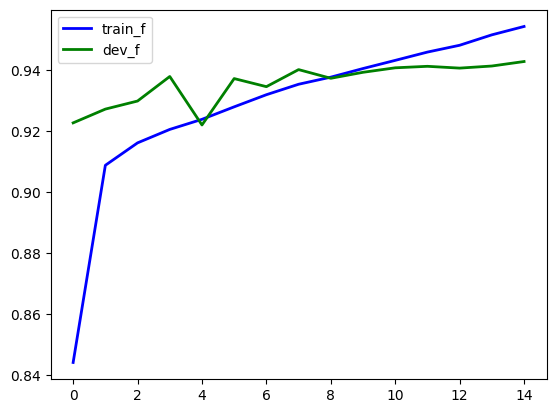

In [ ]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'dev_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()

In [ ]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(16895, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
labels = label_field.vocab.itos[2:]
#labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]
target_names = [str(x) for x in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = target_names)

test perf (0.9192113845241625, 0.9192113845241625, 0.9192113845241625, None)
              precision    recall  f1-score   support

           2       0.94      0.99      0.97      4644
           0       0.92      0.80      0.85      1924
           1       0.36      0.35      0.36       178

    accuracy                           0.92      6746
   macro avg       0.74      0.71      0.73      6746
weighted avg       0.92      0.92      0.92      6746



In [ ]:
# train_sents = dataset[:int(0.8*len(dataset))]
# dev_sents = dataset[int(0.8*len(dataset)):int(0.9*len(dataset))]
# test_sents = dataset[int(0.9*len(dataset)):]

tc = 0
wc = 0
for x in train_sents:
  for y in x:
    tc = tc + y[1]
  wc = wc + len(x)

print(tc, wc, tc/wc)

tc = 0
wc = 0
for x in dev_sents:
  for y in x:
    tc = tc + y[1]
  wc = wc + len(x)

print(tc, wc, tc/wc)

tc = 0
wc = 0
for x in test_sents:
  for y in x:
    tc = tc + y[1]
  wc = wc + len(x)

print(tc, wc, tc/wc)